# Low-VA Simple Models- Hyperparameter Tuning

Hyperparameter tuning on all models, including the number of units for the dense layer, the dropout rate for the dropout layers, and the optimal learning rate.

In [1]:
#change your dependencies as you see fit
import tensorflow as tf
import tensorflow_datasets as tfds
import keras_tuner as kt
import numpy as np
import pandas as pd
from PIL import Image
import glob 
import matplotlib.pyplot as plt
import h5py 
import random 
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MultiLabelBinarizer

import csv
from collections import OrderedDict

%load_ext tensorboard
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

tf.keras.backend.set_image_data_format('channels_last')

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 31.6 gigabytes of available RAM

You are using a high-RAM runtime!


# Loading Data
Loading the tokens (CUI's extracted from CLAMP) as one-hot embeddings (for both positive and negative terms). We have ignored the named entities that do not have a CUI mapped to it

In [4]:
clamp_output_df = pd.read_csv('gs://stanfordoptimagroup/STRIDE/lowva/clamp_output_postprocessing.csv', delimiter = ",")

In [5]:
# code to load the pre-trained embeddings and dataset
def isfloat(value):
    try:
        float(value)
        return True
    except ValueError:
        return False

csv.field_size_limit(1310720);

print('\nloading structured data')
with open('../lowva-structured-02.csv', 'r') as f:
    r = csv.reader(f)
    i = 0
    structuredDict = {}
    outputDict = {}
    for row in r:
        i += 1
        if i == 1:
            continue
        else:
            key = row[0].strip()
            values = np.array([float(i) for i in row[2:] if isfloat(i)])
            structuredDict[key] = values
            outputDict[key]= np.array([int(row[1])])

131072


loading structured data


In [6]:
print('\nCreating tokenDict')
tokenDict=OrderedDict() #to ensure that the dictionary will maintain an order

def check_negation(row):
    if(row['Assertion'] == 'present'):
        return row['CUI_clean'] + 'p'
    else:
        return row['CUI_clean'] + 'n'

for index, row in clamp_output_df.iterrows():
    if (str(row['PID']) in structuredDict): #make sure only including ones that have output results
        if (isinstance(row['CUI_clean'], str)):
            key = str(row['PID'])
            if (key in tokenDict):
                oldValue = tokenDict[key]
                oldValue.append(check_negation(row))
                tokenDict[key] = oldValue
            else: 
                tokenDict[key] = [check_negation(row)]
token_df = pd.DataFrame(list(tokenDict.items()),columns = ['PID','CUI']) 

print('------------------------------------ Token Dataframe- list of all CUIs ------------------------------------')
display(token_df)

# One hot encoding
mlb = MultiLabelBinarizer(sparse_output=True)

tokensOneHot = pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(token_df.pop('CUI')),
                index=token_df.index,
                columns=mlb.classes_)
print('------------------------------------ TokensArray- one hot encoding------------------------------------')
display(tokensOneHot)

#Variance Filtering: filtering out near zero variance features from data frame while preserving names
selector = VarianceThreshold(.99 * (1 - .99))
tokensArray = selector.fit_transform(tokensOneHot)


Creating tokenDict
------------------------------------ Token Dataframe- list of all CUIs ------------------------------------


,PID,CUI
0,1790,"[C0154863p, C0242383p, C0086543p, C0586742p, C..."
1,2262,"[C0030193p, C0022107p, C0332575p, C0039409p, C..."
2,2736,"[C0154863p, C0743690p, C0043253p, C3665347p, C..."
3,2920,"[C0700325p, C3234800p, C1721374p, C0007389p, C..."
4,3178,"[C0024437p, C0593887p, C0017601p, C0085096p, C..."
...,...,...
4388,3840336,"[C0201925p, C0220825p, C0749189p, C2126073p, C..."
4389,3840713,"[C0220825p, C0582103p, C0008809p, C2064449p, C..."
4390,3840904,"[C0344232p, C2126074p, C4554308p, C0012569p, C..."
4391,3840966,"[C0944554p, C0344232p, C0700135p, C0016242n, C..."


------------------------------------ TokensArray- one hot encoding------------------------------------


,C0000294p,C0000578n,C0000618p,C0000729p,C0000734n,C0000735p,C0000737n,C0000737p,C0000768n,C0000768p,...,C4750866p,C4751158p,C4751179p,C4751436p,C4758057p,C4759290p,C4759301p,C4759475p,C4759549n,C4759549p
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4391,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print('loading and joining with unstructured data')

outputArray = []
structuredArray = []
for key in tokenDict: #to make sure that it's the same order as the tokenArray
    structvalues = structuredDict[key]
    output = outputDict[key]
    
    structuredArray.append(structvalues)
    outputArray.append(output)

outputArray = np.array(outputArray)
structuredArray = np.array(structuredArray)
tokenArray = tokensArray.toarray() # after variance filtering, need to convert from sparse array to dense

print(tokenArray.shape, structuredArray.shape, outputArray.shape)

loading and joining with unstructured data
(4393, 1078) (4393, 556) (4393, 1)


# Model Hyperparameter Tuning

## Model A) Structured Model

In [8]:
total_input = tf.data.Dataset.from_tensor_slices(structuredArray)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

2021-10-20 01:23:39.851191: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
def model_builder(hp):
    dense1_hp_units = hp.Int('dense_1', min_value=32, max_value=1024, step=32)
    dense2_hp_units = hp.Int('dense_2', min_value=32, max_value=1024, step=32)
    dropout1_hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    input2 = tf.keras.Input(shape=(structuredArray.shape[1],))
    sl = tf.keras.layers.Dense(units = dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
    sl = tf.keras.layers.Dropout(rate = dropout1_hp_units)(sl)
    sl = tf.keras.layers.Dense(units = dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(sl)
    
    model = tf.keras.Model(inputs = input2, outputs = output)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [74]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct00',
                     overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: {best_hps.get('dense_1')}
Dropout layer: {best_hps.get('dropout_1')}
Second densely-connected layer: {best_hps.get('dense_2')}
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 21s]
val_accuracy: 0.7133333086967468

Best val_accuracy So Far: 0.7766666412353516
Total elapsed time: 00h 14m 07s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: 480
Dropout layer: 0.5
Second densely-connected layer: 608
Optimal learning rate: 0.001.



Best results: \
First densely-connected layer: 480 \
Dropout layer: 0.5 \
Second densely-connected layer: 608 \
Optimal learning rate: 0.001

## (Model C) CUI One-Hot Encoding Text Model

In [78]:
total_input = tf.data.Dataset.from_tensor_slices(tokenArray)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [79]:
def model_builder(hp):
    dense1_hp_units = hp.Int('dense_1', min_value=32, max_value=1024, step=32)
    dense2_hp_units = hp.Int('dense_2', min_value=32, max_value=1024, step=32)
    dropout1_hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    input2 = tf.keras.Input(shape=(tokenArray.shape[1],))
    sl = tf.keras.layers.Dense(units = dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
    sl = tf.keras.layers.Dropout(rate = dropout1_hp_units)(sl)
    sl = tf.keras.layers.Dense(units = dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(sl)
    
    model = tf.keras.Model(inputs = input2, outputs = output)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [80]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct01',
                     overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: {best_hps.get('dense_1')}
Dropout layer: {best_hps.get('dropout_1')}
Second densely-connected layer: {best_hps.get('dense_2')}
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 12s]
val_accuracy: 0.6366666555404663

Best val_accuracy So Far: 0.6499999761581421
Total elapsed time: 00h 10m 50s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: 608
Dropout layer: 0.4
Second densely-connected layer: 608
Optimal learning rate: 0.0001.



Best results:\
First densely-connected layer: 608\
Dropout layer: 0.4\
Second densely-connected layer: 608\
Optimal learning rate: 0.0001

## (Model F) Structured and CUI one-hot combined model

In [86]:
total_input = tf.data.Dataset.from_tensor_slices(np.hstack((tokenArray, structuredArray)))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [87]:
def model_builder(hp):
    dense1_hp_units = hp.Int('dense_1', min_value=32, max_value=1024, step=32)
    dense2_hp_units = hp.Int('dense_2', min_value=32, max_value=1024, step=32)
    dropout1_hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    input2 = tf.keras.Input(shape=((tokenArray.shape[1]+structuredArray.shape[1]),))
    sl = tf.keras.layers.Dense(units = dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
    sl = tf.keras.layers.Dropout(rate = dropout1_hp_units)(sl)
    sl = tf.keras.layers.Dense(units = dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(sl)
    
    model = tf.keras.Model(inputs = input2, outputs = output)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [88]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct02',
                     overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: {best_hps.get('dense_1')}
Dropout layer: {best_hps.get('dropout_1')}
Second densely-connected layer: {best_hps.get('dense_2')}
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

Trial 90 Complete [00h 00m 18s]
val_accuracy: 0.7833333611488342

Best val_accuracy So Far: 0.7900000214576721
Total elapsed time: 00h 12m 19s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: 704
Dropout layer: 0.5
Second densely-connected layer: 448
Optimal learning rate: 0.001.



Best results:\
First densely-connected layer: 704\
Dropout layer: 0.5\
Second densely-connected layer: 448\
Optimal learning rate: 0.001

# Word embedding with pretrained cui2vec embedding

### Loading CUI's to create cui2vec embeddings (converting to "sentence of cui's")

In [8]:
# Variance Threshold for word embedding (cui2vec)
selector = VarianceThreshold(.99 * (1 - .99));
selector.fit(tokensOneHot);
tokenArray_df = tokensOneHot[tokensOneHot.columns[selector.get_support(indices=True)]]

display(tokenArray_df)

VarianceThreshold(threshold=0.00990000000000001)

<class 'pandas.core.frame.DataFrame'>


,C0000737n,C0000975p,C0001367p,C0001425p,C0001927p,C0002418p,C0002600p,C0002645p,C0002871n,C0002871p,...,C4699683p,C4699689p,C4700122p,C4700200n,C4708770p,C4718671n,C4718671p,C4738298p,C4745561p,C4748411p
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4388,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4389,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4390,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4391,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
vocabulary = set()
cuiDict={}

# Returning only positive cui's
def adapt_cui(cui):
    if 'n' in cui:
        return ' '
    if 'p' in cui:
        return cui[0:len(cui)-1]

# creating a vocab out of the cui's (creating a sentence from the extracted name-entities)
pid_list_tokenDict = [*tokenDict]

for index, row in tokenArray_df.iterrows(): #tokenArray_df is after variance filtering
    for column in tokenArray_df: #iterating through all the columns to get the cui's
        if (row[column] == 1): #only if patient has the cui
            value = adapt_cui(column)
            vocabulary.add(value)
            key = pid_list_tokenDict[index]
            if (key in cuiDict):
                oldValue = cuiDict[key]
                newValue = oldValue + ' ' + value
                cuiDict[key] = newValue
            else: 
                cuiDict[key] = value

print(len(cuiDict))

4392


In [10]:
# Loading pertrained cui2vec embedding

print('loading cui2vec vectors')
cui2vec_df = pd.read_csv('gs://stanfordoptimagroup/STRIDE/lowva/cui2vec_pretrained.csv', delimiter = ",")
cui2vec_df.rename(columns={'Unnamed: 0':'CUI'}, inplace=True)
cui2vec_map = cui2vec_df.set_index('CUI').T.to_dict('list') # Create dictionary from df

print('Loaded %s word vectors.' % len(cui2vec_map))

loading cui2vec vectors
Loaded 109053 word vectors.


### Loading pubmed word embeddings

In [8]:
extrinsicdata_df = pd.read_csv('../lowva-extrinsicdata.csv', delimiter = ",", header=None)

In [12]:
vocabulary_pubmed = []
with open('../pubmed_cbow_vocabulary.txt', 'r') as f:
    for row in f:
        vocabulary_pubmed.append(row.strip())

# Create Tokenizer
vocabulary_pubmed_size = len(vocabulary_pubmed) + 2
print('Vocab Pubmed Size', vocabulary_pubmed_size)
tokenizer_pubmed = tfds.deprecated.text.Tokenizer()

width = 1000
pubmed_embedding_dimension = 300
pubmed_encoder = tfds.deprecated.text.TokenTextEncoder(vocabulary_pubmed, tokenizer = tokenizer_pubmed)

print('Creating wordDict')
wordDict = {}

for index, row in extrinsicdata_df.iterrows():
    if (str(row[0]) in cuiDict): #make sure only including ones that have output results
        key = str(row[0])
        words = pubmed_encoder.encode(row[2])
        words = words[0:width]
        if len(words) < width:
            words = words + [0 for i in range(width-len(words))] 
        wordDict[key] = words

print('Max Length of words in patient:', width)

print('loading Pubmed EMR vectors')
model = tf.keras.models.load_model('../pubmed_cbow_embeddings.h5')
pubmed_embedding_matrix = np.zeros((vocabulary_pubmed_size, pubmed_embedding_dimension))
pubmed_e = model.layers[1]
pubmed_embedding_matrix = pubmed_e.get_weights()[0]
print(pubmed_embedding_matrix.shape)
del model

Vocab Pubmed Size 55940
Creating wordDict
Max Length of words in patient: 1000
loading Pubmed EMR vectors


2021-09-15 04:25:57.985551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(55940, 300)


### Creating inputs (structuredArray, outputArray, wordArray, padded_cui)

In [13]:
# need to rerun because we are removing terms that are negative (might affect patient count)
outputArray = []
structuredArray = []
cuiArray = []
wordArray = []

for key in wordDict: #to make sure that everything is same order
    structvalues = structuredDict[key]
    output = outputDict[key]
    cui = cuiDict[key]
    word = wordDict[key] #TOGGLE
    
    structuredArray.append(structvalues)
    outputArray.append(output)
    cuiArray.append(cui)
    wordArray.append(word) #TOGGLE

outputArray = np.array(outputArray)
structuredArray = np.array(structuredArray)
wordArray = np.array(wordArray)

print(structuredArray.shape, outputArray.shape, len(cuiArray), wordArray.shape)

(4392, 556) (4392, 1) 4392 (4392, 1000)


In [14]:
# Create Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(cuiArray)
vocabulary_size = len(vocabulary) + 1
print('Vocab Size', vocabulary_size)

# Integer encode the documents
encoded_cui = tokenizer.texts_to_sequences(cuiArray)
# print(encoded_cui)

# Pad documents to max length
max_length = max(map(len, encoded_cui)) #getting max length of the number of cui's per patient

# max_length = 4000 #arbitrary number set to decrease the size (only 3 patients have more than 4000 cui's)
padded_cui = tf.keras.preprocessing.sequence.pad_sequences(encoded_cui, maxlen = max_length, padding='post')
print(padded_cui)
print(padded_cui.shape)
print('Max Length of CUI in patient:', max_length)

Vocab Size 816
[[ 61   4   9 ...   0   0   0]
 [  8 357  15 ...   0   0   0]
 [ 98  18   6 ...   0   0   0]
 ...
 [  8 331 249 ...   0   0   0]
 [  8  61   4 ...   0   0   0]
 [280 505 807 ...   0   0   0]]
(4392, 239)
Max Length of CUI in patient: 239


In [15]:
# Create cui2vec embedding

embedding_dimension = 500 #number pulled from the cui2vec pretrained word embeddings
embedding_matrix = np.zeros((vocabulary_size, embedding_dimension))

print('Loaded %s word vectors.' % len(cui2vec_map))

# Creating a weight matrix for words in the training docs
for word, i in tokenizer.word_index.items():
    embedding_vector = cui2vec_map.get(word.upper()) #need to convert to upper case b/c tokenizer makes all lowercase
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Loaded 109053 word vectors.
(816, 500)


In [16]:
del clamp_output_df
del token_df
del tokenArray_df
del cui2vec_df
del extrinsicdata_df
del structuredDict
del outputDict
del tokenDict
del pid_list_tokenDict
del cuiDict
del wordDict

## (Model D) Cui2vec text model

In [16]:
total_input = tf.data.Dataset.from_tensor_slices(padded_cui)
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)
max_length = max(map(len, encoded_cui))

In [19]:
def model_builder(hp):
    dense1_hp_units = hp.Int('dense_1', min_value=32, max_value=512, step=32)
    dense2_hp_units = hp.Int('dense_2', min_value=32, max_value=512, step=32)
    dropout1_hp_units = hp.Float('dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    input1 = tf.keras.Input(shape=(max_length,))
    nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
    nl = tf.keras.layers.Flatten()(nl)
    nl = tf.keras.layers.Dense(units = dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
    nl = tf.keras.layers.Dropout(rate = dropout1_hp_units)(nl)
    nl = tf.keras.layers.Dense(units = dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)
    
    model = tf.keras.Model(inputs = input1, outputs = output)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct03');
#                      overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: {best_hps.get('dense_1')}
Dropout layer: {best_hps.get('dropout_1')}
Second densely-connected layer: {best_hps.get('dense_2')}
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_tuning/struct03/oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameter_tuning/struct03/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
----------------------------------------------
Best results:
First densely-connected layer: 224
Dropout layer: 0.30000000000000004
Second densely-connected layer: 128
Optimal learning rate: 0.0001.



Best results:\
First densely-connected layer: 224\
Dropout layer: 0.30000000000000004\
Second densely-connected layer: 128\
Optimal learning rate: 0.0001.

# (3.2) Pubmed word embedding + structured

In [ ]:
total_input = tf.data.Dataset.from_tensor_slices((wordArray, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)
max_length = max(map(len, encoded_cui))

In [ ]:
def model_builder(hp):
    pubmed_dense1_hp_units = hp.Int('pubmed_dense_1', min_value=32, max_value=1024, step=32)
    pubmed_dense2_hp_units = hp.Int('pubmed_dense_2', min_value=32, max_value=1024, step=32)
    pubmed_dropout1_hp_units = hp.Float('pubmed_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    struct_dense1_hp_units = hp.Int('struct_dense_1', min_value=32, max_value=1024, step=32)
    struct_dense2_hp_units = hp.Int('struct_dense_2', min_value=32, max_value=1024, step=32)
    struct_dropout1_hp_units = hp.Float('struct_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    combo_dense1_hp_units = hp.Int('combo_dense_1', min_value=32, max_value=1024, step=32)
    
    input2 = tf.keras.Input(shape=(width,))
    nl2 = tf.keras.layers.Embedding(vocabulary_pubmed_size, pubmed_embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(pubmed_embedding_matrix), input_length = width, trainable=False)(input2)
    nl2 = tf.keras.layers.Flatten()(nl2)
    nl2 = tf.keras.layers.Dense(units = pubmed_dense_1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl2)
    nl2 = tf.keras.layers.Dropout(rate = pubmed_dropout_1)(nl2)
    nl2 = tf.keras.layers.Dense(units = pubmed_dense_2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl2)

    input3 = tf.keras.Input(shape=(structuredArray.shape[1],))
    sl = tf.keras.layers.Dense(units = struct_dense_1, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input3)
    sl = tf.keras.layers.Dropout(rate = struct_dropout_1)(sl)
    sl = tf.keras.layers.Dense(units = struct_dense_2, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)

    combo = tf.keras.layers.Concatenate()([nl2, sl])
    combo = tf.keras.layers.Dense(units = combo_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo)
    nl = combo

    output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)
    
    model = tf.keras.Model(inputs = (input2, input3), outputs = output)
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct032',
                     overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
Pubmed- first densely-connected layer: {best_hps.get('pubmed_dense_1')}
Pubmed- dropout layer: {best_hps.get('pubmed_dropout_1')}
Pubmed- second densely-connected layer: {best_hps.get('pubmed_dense_2')}
Struct- first densely-connected layer: {best_hps.get('struct_dense_1')}
Struct- dropout layer: {best_hps.get('struct_dropout_1')}
Struct- second densely-connected layer: {best_hps.get('struct_dense_2')}
Combo- densely-connected layer: {best_hps.get('combo_dense_1')}
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

# (Model E) Structured + CNN word embedding Combined Model

In [23]:
total_input = tf.data.Dataset.from_tensor_slices((padded_cui, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [24]:
def model_builder(hp):
    cui2vec_dense1_hp_units = hp.Int('cui2vec_dense_1', min_value=32, max_value=512, step=32)
    cui2vec_dense2_hp_units = hp.Int('cui2vec_dense_2', min_value=32, max_value=512, step=32)
    cui2vec_dropout1_hp_units = hp.Float('cui2vec_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    struct_dense1_hp_units = hp.Int('struct_dense_1', min_value=32, max_value=1024, step=32)
    struct_dense2_hp_units = hp.Int('struct_dense_2', min_value=32, max_value=1024, step=32)
    struct_dropout1_hp_units = hp.Float('struct_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    combo_dense1_hp_units = hp.Int('combo_dense_1', min_value=32, max_value=1024, step=32)
    
    input1 = tf.keras.Input(shape=(max_length,))
    nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
    nl = tf.keras.layers.Flatten()(nl)
    nl = tf.keras.layers.Dense(units = cui2vec_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
    nl = tf.keras.layers.Dropout(rate = cui2vec_dropout1_hp_units)(nl)
    nl = tf.keras.layers.Dense(units = cui2vec_dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

    input2 = tf.keras.Input(shape=(structuredArray.shape[1],))
    sl = tf.keras.layers.Dense(units = struct_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
    sl = tf.keras.layers.Dropout(rate = struct_dropout1_hp_units)(sl)
    sl = tf.keras.layers.Dense(units = struct_dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)

    combo = tf.keras.layers.Concatenate()([nl, sl])
    combo = tf.keras.layers.Dense(units = combo_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo)
    nl = combo

    output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

    model = tf.keras.Model(inputs = (input1, input2), outputs = output)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [25]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct035')
#                      overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
Cui2vec- first densely-connected layer: {best_hps.get('cui2vec_dense_1')}
Cui2vec- dropout layer: {best_hps.get('cui2vec_dropout_1')}
Cui2vec- second densely-connected layer: {best_hps.get('cui2vec_dense_2')}
Struct- first densely-connected layer: {best_hps.get('struct_dense_1')}
Struct- dropout layer: {best_hps.get('struct_dropout_1')}
Struct- second densely-connected layer: {best_hps.get('struct_dense_2')}
Combo- densely-connected layer: {best_hps.get('combo_dense_1')}
Optimal learning rate: {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_tuning/struct035/oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameter_tuning/struct035/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
----------------------------------------------
Best results:
Cui2vec- first densely-connected layer: 128
Cui2vec- dropout layer: 0.6000000000000001
Cui2vec- second densely-connected layer: 320
Struct- first densely-connected layer: 416
Struct- dropout layer: 0.5
Struct- second densely-connected layer: 480
Combo- densely-connected layer: 448
Optimal learning rate: 0.001.



Best results:\
Cui2vec- first densely-connected layer: 128\
Cui2vec- dropout layer: 0.6000000000000001\
Cui2vec- second densely-connected layer: 320\
Struct- first densely-connected layer: 416\
Struct- dropout layer: 0.5\
Struct- second densely-connected layer: 480\
Combo- densely-connected layer: 448\
Optimal learning rate: 0.001

# (Model H) Structured and cui2vec text model and fully connected word embedding model

In [19]:
#total_input = tf.data.Dataset.from_tensor_slices(structuredArray)
#total_input = tf.data.Dataset.from_tensor_slices(tokenArray)
total_input = tf.data.Dataset.from_tensor_slices((padded_cui, wordArray, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)

In [22]:
def model_builder(hp):
    cui2vec_dense1_hp_units = hp.Int('cui2vec_dense_1', min_value=32, max_value=512, step=32)
    cui2vec_dense2_hp_units = hp.Int('cui2vec_dense_2', min_value=32, max_value=512, step=32)
    cui2vec_dropout1_hp_units = hp.Float('cui2vec_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    pubmed_dense1_hp_units = hp.Int('pubmed_dense_1', min_value=32, max_value=512, step=32)
    pubmed_convo_hp_units = hp.Int('pubmed_convo_size', min_value=32, max_value=512, step=32)
    pubmed_dropout1_hp_units = hp.Float('pubmed_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    pubmed_dense3_hp_units = hp.Int('pubmed_dense_3', min_value=32, max_value=1024, step=32)
    pubmed_dropout2_hp_units = hp.Float('pubmed_dropout_2', min_value=0.0, max_value=0.9, step=0.1)
    
    struct_dense1_hp_units = hp.Int('struct_dense_1', min_value=32, max_value=1024, step=32)
    struct_dense2_hp_units = hp.Int('struct_dense_2', min_value=32, max_value=1024, step=32)
    struct_dropout1_hp_units = hp.Float('struct_dropout_1', min_value=0.0, max_value=0.9, step=0.1)
    
    combo_dense1_hp_units = hp.Int('combo_dense_1', min_value=32, max_value=1024, step=32)
    combo_dense2_hp_units = hp.Int('combo_dense_2', min_value=32, max_value=1024, step=32)
    combo_dropout1_hp_units = hp.Float('combo_dropout_1', min_value=0.0, max_value=0.9, step=0.1)

    #padded_cui cui2vec embedding
    input1 = tf.keras.Input(shape=(max_length,))
    nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
    nl = tf.keras.layers.Flatten()(nl)
    nl = tf.keras.layers.Dense(units = cui2vec_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
    nl = tf.keras.layers.Dropout(rate = cui2vec_dropout1_hp_units)(nl)
    nl = tf.keras.layers.Dense(units = cui2vec_dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

    #pubmed CNN
    input2 = tf.keras.Input(shape=(width,))
    nl2 = tf.keras.layers.Embedding(vocabulary_pubmed_size, pubmed_embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(pubmed_embedding_matrix), input_length = width, trainable=False)(input2)
    nl2 = tf.keras.layers.Dense(pubmed_dense1_hp_units, activation='relu')(nl2) 
    nl2 = tf.keras.layers.Dropout(pubmed_dropout1_hp_units)(nl2) 
    kernels = [3, 5, 7, 10] 
    pooled = [] 
    for kernel_size in kernels: 
        mini_layer = tf.keras.layers.Conv1D(pubmed_convo_hp_units, kernel_size, activation='relu')(nl2) 
        mini_pooled = tf.keras.layers.MaxPooling1D(width - kernel_size + 1)(mini_layer) 
        pooled.append(mini_pooled) 
    nl2 = tf.keras.layers.Concatenate(axis=1)(pooled) 
    nl2 = tf.keras.layers.Flatten()(nl2) 
    nl2 = tf.keras.layers.Dropout(pubmed_dropout2_hp_units)(nl2) 
    nl2 = tf.keras.layers.Dense(pubmed_dense3_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl2) 
    
    #structured
    input3 = tf.keras.Input(shape=(structuredArray.shape[1],))
    sl = tf.keras.layers.Dense(units = struct_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input3)
    sl = tf.keras.layers.Dropout(rate = struct_dropout1_hp_units)(sl)
    sl = tf.keras.layers.Dense(units = struct_dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)

    combo = tf.keras.layers.Concatenate()([nl, nl2, sl])
    combo = tf.keras.layers.Dense(combo_dense1_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo) 
    combo = tf.keras.layers.Dropout(combo_dropout1_hp_units)(combo) 
    combo = tf.keras.layers.Dense(combo_dense2_hp_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo)

    output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

    model = tf.keras.Model(inputs = (input1, input2, input3), outputs = output)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [24]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=80,
                     directory='hyperparameter_tuning',
#                      project_name='lowva')
                     project_name='struct05_newModelH');
#                      overwrite=True);

callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1),
]

tuner.search(train_dataset, epochs=80, validation_data=validation_dataset, callbacks=callbacks)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
----------------------------------------------
Best results:
Cui2vec- first densely-connected layer: {best_hps.get('cui2vec_dense_1')}
Cui2vec- dropout layer: {best_hps.get('cui2vec_dropout_1')}
Cui2vec- second densely-connected layer: {best_hps.get('cui2vec_dense_2')}

Pubmed- first densely-connected layer: {best_hps.get('pubmed_dense_1')}
Pubmed- dropout layer: {best_hps.get('pubmed_dropout_1')}
Pubmed- convo size layer: {best_hps.get('pubmed_convo_size')}
Pubmed- third densely-connected layer: {best_hps.get('pubmed_dense_3')}
Pubmed- dropout layer 2: {best_hps.get('pubmed_dropout_2')}

Struct- first densely-connected layer: {best_hps.get('struct_dense_1')}
Struct- dropout layer: {best_hps.get('struct_dropout_1')}
Struct- second densely-connected layer: {best_hps.get('struct_dense_2')}

Combo- densely-connected layer: {best_hps.get('combo_dense_1')}
Combo- densely-connected layer 2: {best_hps.get('combo_dense_2')}
Combo- dropout: {best_hps.get('combo_dropout_1')}

Optimal learning rate: {best_hps.get('learning_rate')}.
""")

INFO:tensorflow:Reloading Oracle from existing project hyperparameter_tuning/struct05_newModelH/oracle.json
INFO:tensorflow:Reloading Tuner from hyperparameter_tuning/struct05_newModelH/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete.
----------------------------------------------
Best results:
Cui2vec- first densely-connected layer: 384
Cui2vec- dropout layer: 0.6000000000000001
Cui2vec- second densely-connected layer: 288

Pubmed- first densely-connected layer: 96
Pubmed- dropout layer: 0.1
Pubmed- convo size layer: 160
Pubmed- third densely-connected layer: 608
Pubmed- dropout layer 2: 0.8

Struct- first densely-connected layer: 896
Struct- dropout layer: 0.8
Struct- second densely-connected layer: 896

Combo- densely-connected layer: 288
Combo- densely-connected layer 2: 864
Combo- dropout: 0.30000000000000004

Optimal learning rate: 0.0001.



Best results:\
Cui2vec- first densely-connected layer: 384\
Cui2vec- dropout layer: 0.6000000000000001\
Cui2vec- second densely-connected layer: 288\
                
Pubmed- first densely-connected layer: 96\
Pubmed- dropout layer: 0.1\
Pubmed- convo size layer: 160\
Pubmed- third densely-connected layer: 608\
Pubmed- dropout layer 2: 0.8\

Struct- first densely-connected layer: 896\
Struct- dropout layer: 0.8\
Struct- second densely-connected layer: 896\

Combo- densely-connected layer: 288\
Combo- densely-connected layer 2: 864\
Combo- dropout: 0.30000000000000004\

Optimal learning rate: 0.0001

In [90]:
#total_input = tf.data.Dataset.from_tensor_slices(structuredArray)
#total_input = tf.data.Dataset.from_tensor_slices(tokenArray)
total_input = tf.data.Dataset.from_tensor_slices((padded_cui, structuredArray))
total_output = tf.data.Dataset.from_tensor_slices(outputArray)
total_dataset = tf.data.Dataset.zip((total_input, total_output))
train_dataset = total_dataset.skip(600).shuffle(1000).batch(15)
validation_dataset = total_dataset.skip(300).take(300).batch(15)
test_dataset = total_dataset.take(300).batch(15)
max_length = 2000

In [91]:
input1 = tf.keras.Input(shape=(max_length,))
nl = tf.keras.layers.Embedding(vocabulary_size, embedding_dimension, embeddings_initializer = tf.keras.initializers.Constant(embedding_matrix), input_length = max_length, trainable=False)(input1)
nl = tf.keras.layers.Dense(512, activation='relu')(nl)
nl = tf.keras.layers.Dropout(0.50)(nl)
kernels = [3, 5, 7, 10]
pooled = []
for kernel_size in kernels:
    mini_layer = tf.keras.layers.Conv1D(256, kernel_size, activation='relu')(nl)
    mini_pooled = tf.keras.layers.MaxPooling1D(max_length - kernel_size + 1)(mini_layer)
    pooled.append(mini_pooled)
nl = tf.keras.layers.Concatenate(axis=1)(pooled)
nl = tf.keras.layers.Flatten()(nl)
nl = tf.keras.layers.Dropout(0.50)(nl)
nl = tf.keras.layers.Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)
nl = tf.keras.layers.Dropout(0.5)(nl)
nl = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(nl)

input2 = tf.keras.Input(shape=(structuredArray.shape[1],))
sl = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(input2)
sl = tf.keras.layers.Dropout(0.50)(sl)
sl = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(sl)

combo = tf.keras.layers.Concatenate()([nl, sl])
combo = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2())(combo)
nl = combo

output = tf.keras.layers.Dense(1, activation='sigmoid')(nl)

#model = tf.keras.Model(inputs = input1, outputs = output)
#model = tf.keras.Model(inputs = input2, outputs = output)
model = tf.keras.Model(inputs = (input1, input2), outputs = output)

model.summary()

metrics = [
    tf.keras.metrics.TruePositives(name='tp'), 
    tf.keras.metrics.FalsePositives(name='fp'), 
    tf.keras.metrics.TrueNegatives(name='tn'), 
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.Recall(name='sen'), 
    tf.keras.metrics.Precision(name='prc'), 
    tf.keras.metrics.AUC(name='auroc'), 
    tf.keras.metrics.BinaryAccuracy(name='acc')
]
callbacks=[
    tf.keras.callbacks.EarlyStopping(patience=4, verbose=1, restore_best_weights=True, min_delta=0.0001), 
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=2, verbose=1)
]
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='binary_crossentropy', metrics=metrics)
history = model.fit(train_dataset, epochs=80, validation_data=validation_dataset, verbose=1, callbacks=callbacks)
model.evaluate(validation_dataset)
y_pred = model.predict(validation_dataset)
model.save_weights('struct05_lowva_weights-XXXX')

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 2000)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 2000, 500)    7867000     input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 2000, 512)    256512      embedding_1[0][0]                
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2000, 512)    0           dense_10[0][0]                   
____________________________________________________________________________________________

ValueError: in user code:

    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/envs/haiwen/lib/python3.9/site-packages/tensorflow/python/keras/engine/input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_2: expected shape=(None, 2000), found shape=(None, 4000)


loss: 0.6591 - tp: 62.0000 - fp: 39.0000 - tn: 160.0000 - fn: 39.0000 - sen: 0.6139 - prc: 0.6139 - auroc: 0.7664 - acc: 0.7400

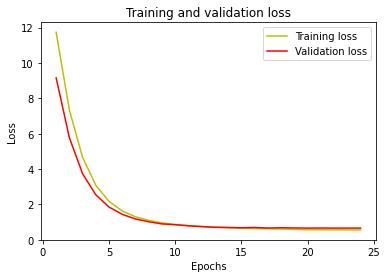

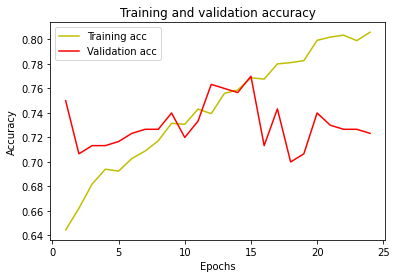

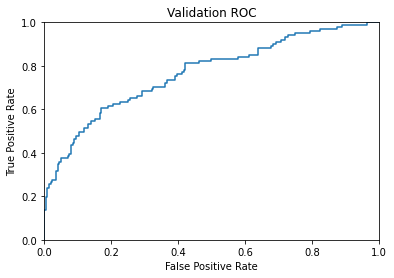

In [31]:
plt_loss(history)
plt_acc(history)
plt_roc(validation_dataset, y_pred)